## Imports and model initialization

In [1]:
# !pip install kipoi
# !pip install kipoiseq
# !pip install pybedtools
# !pip uninstall -y kipoi_veff
# !pip install git+https://github.com/an1lam/kipoi-veff
# !pip install pyvcf
import kipoi
from kipoi_interpret.importance_scores.ism import Mutation
from kipoiseq.dataloaders import SeqIntervalDl
from matplotlib import pyplot as plt
import numpy as np

In [2]:
!pwd

/home/stephenmalina/project/src


# Loading DNA sequence data

In [3]:
dl = SeqIntervalDl("../dat/ChIPseq.A549.CTCF.1000.random.narrowPeak.gz", "../dat/hg19.fa", auto_resize_len=1000)
data = dl.load_all()

100%|██████████| 32/32 [00:02<00:00, 14.07it/s]


In [4]:
seqs = np.expand_dims(data['inputs'].transpose(0, 2, 1), 2).astype(np.float32)
seqs.shape

(1001, 4, 1, 1000)

# Loading DeepSEA

In [5]:
import tensorflow as tf
print("TF version:", tf.__version__)
import torch
print("torch version:", torch.__version__)
from torch import nn

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

TF version: 1.14.0
torch version: 1.3.1


In [6]:
# df = kipoi.list_models()
# deepsea_models = df[df.model.str.contains("DeepSEA")]
# deepsea_models.head()

In [7]:
deepsea = kipoi.get_model("DeepSEA/predict", source="kipoi")
deepsea.model

Using downloaded and verified file: /home/stephenmalina/.kipoi/models/DeepSEA/predict/downloaded/model_files/weights/89e640bf6bdbe1ff165f484d9796efc7


Sequential(
  (0): ReCodeAlphabet()
  (1): ConcatenateRC()
  (2): Sequential(
    (0): Conv2d(4, 320, kernel_size=(1, 8), stride=(1, 1))
    (1): Threshold(threshold=0, value=1e-06)
    (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(320, 480, kernel_size=(1, 8), stride=(1, 1))
    (5): Threshold(threshold=0, value=1e-06)
    (6): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(480, 960, kernel_size=(1, 8), stride=(1, 1))
    (9): Threshold(threshold=0, value=1e-06)
    (10): Dropout(p=0.5, inplace=False)
    (11): Lambda()
    (12): Sequential(
      (0): Lambda()
      (1): Linear(in_features=50880, out_features=925, bias=True)
    )
    (13): Threshold(threshold=0, value=1e-06)
    (14): Sequential(
      (0): Lambda()
      (1): Linear(in_features=925, out_features=919, bias=True)
    )
    (15):

In [8]:
deepsea.pipeline.predict_example().shape

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


(10, 919)

# Hacking DeepSEA's layers
This section is focused on tweaking DeepSEA's model to use dropout when making predictions.

In [9]:
# (Legally) grabbed from:
# https://pytorchnlp.readthedocs.io/en/latest/_modules/torchnlp/nn/lock_dropout.html.
class LockedDropout(nn.Module):
    """ LockedDropout applies the same dropout mask to every time step.

    **Thank you** to Sales Force for their initial implementation of :class:`WeightDrop`. 
    Here is their `License
    <https://github.com/salesforce/awd-lstm-lm/blob/master/LICENSE>`__.

    Args:
        p (float): Probability of an element in the dropout mask to be zeroed.
    """

    def __init__(self, p=0.5, training=True):
        self.p = p
        self.training = training
        super().__init__()

    def train(self, training=True):
        self.training = training
        
    def forward(self, x):
        """
        Args:
            x (:class:`torch.FloatTensor` [sequence length, batch size, rnn hidden size]):
                Input to apply dropout to.
        """
        if not self.training or not self.p:
            return x
        x = x.clone()
        mask = x.new_empty(1, x.size(1), x.size(2), x.size(3), requires_grad=False)
        mask = mask.bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p) # rescaling
        mask = mask.expand_as(x)
        return x * mask


    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + str(self.p) + ')'

In [10]:
def replace_dropout_layers(model):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = replace_dropout_layers(module)

        if type(module) == nn.Dropout:
             model._modules[name] = LockedDropout(module.p, training=module.training)
        
    return model

In [11]:
from torch import nn

def apply_dropout(m):
    if type(m) == nn.Dropout or type(m) == LockedDropout:
        m.train()
        
def unapply_dropout(m):
    if type(m) == nn.Dropout or type(m) == LockedDropout:
        m.eval()

In [12]:
deepsea.model = replace_dropout_layers(deepsea.model)

### Verifying dropout is being applied
We can verify or at least get reasonable certainty that dropout's being applied by running 10 predictions on the same sequence and then seeing that the predicted binding probs differ. First, we show that the predictions stay the same if dropout is off.

Then, we turn on dropout and show that they start to vary.

In [13]:
deepsea.model = deepsea.model.apply(unapply_dropout)
for i in range(3):
    print(f"First few preds ({i+1}/3): ", deepsea.pipeline.predict_example()[:5])

100%|██████████| 1/1 [00:00<00:00, 28.32it/s]


First few preds (1/3):  [[0.08161031 0.06867661 0.10076798 ... 0.09493414 0.02133885 0.01201447]
 [0.06698208 0.01062424 0.02694638 ... 0.15490864 0.04822354 0.00770117]
 [0.04445557 0.00539728 0.018408   ... 0.14994667 0.35297143 0.02272817]
 [0.00245111 0.00048716 0.00247776 ... 0.01495204 0.04857798 0.00068955]
 [0.00076919 0.00535259 0.00189638 ... 0.01889143 0.06013346 0.02190239]]


100%|██████████| 1/1 [00:00<00:00, 28.58it/s]


First few preds (2/3):  [[0.08161031 0.06867661 0.10076798 ... 0.09493414 0.02133885 0.01201447]
 [0.06698208 0.01062424 0.02694638 ... 0.15490864 0.04822354 0.00770117]
 [0.04445557 0.00539728 0.018408   ... 0.14994667 0.35297143 0.02272817]
 [0.00245111 0.00048716 0.00247776 ... 0.01495204 0.04857798 0.00068955]
 [0.00076919 0.00535259 0.00189638 ... 0.01889143 0.06013346 0.02190239]]


100%|██████████| 1/1 [00:00<00:00, 27.86it/s]


First few preds (3/3):  [[0.08161031 0.06867661 0.10076798 ... 0.09493414 0.02133885 0.01201447]
 [0.06698208 0.01062424 0.02694638 ... 0.15490864 0.04822354 0.00770117]
 [0.04445557 0.00539728 0.018408   ... 0.14994667 0.35297143 0.02272817]
 [0.00245111 0.00048716 0.00247776 ... 0.01495204 0.04857798 0.00068955]
 [0.00076919 0.00535259 0.00189638 ... 0.01889143 0.06013346 0.02190239]]


In [14]:
deepsea.model.eval()
deepsea.model = deepsea.model.apply(apply_dropout)
for i in range(3):
    print(f"First few preds ({i+1}/3): ", deepsea.pipeline.predict_example()[:5])

100%|██████████| 1/1 [00:00<00:00, 24.16it/s]


First few preds (1/3):  [[0.07681333 0.03912929 0.10123628 ... 0.08827041 0.02698844 0.01259604]
 [0.05138661 0.00403897 0.02200725 ... 0.08595882 0.05309746 0.00981179]
 [0.03771478 0.00302182 0.02131673 ... 0.07131455 0.28975853 0.02327987]
 [0.00315452 0.00075396 0.00358108 ... 0.01077588 0.04477182 0.00046336]
 [0.00086056 0.00408345 0.00182946 ... 0.01409261 0.06387445 0.01651232]]


100%|██████████| 1/1 [00:00<00:00, 28.04it/s]


First few preds (2/3):  [[0.10997123 0.09206422 0.1617249  ... 0.08133263 0.02917796 0.01323949]
 [0.03033945 0.00446405 0.01992286 ... 0.2030036  0.07210472 0.00847222]
 [0.0688092  0.00686524 0.02591956 ... 0.16425855 0.35184065 0.02405273]
 [0.00436248 0.00122514 0.00547442 ... 0.0101006  0.05270088 0.00160246]
 [0.00080856 0.00816446 0.00194677 ... 0.02548906 0.09109088 0.02085453]]


100%|██████████| 1/1 [00:00<00:00, 28.80it/s]


First few preds (3/3):  [[0.07547846 0.07388859 0.0957685  ... 0.08911232 0.02015861 0.01248183]
 [0.06769812 0.01020151 0.02871761 ... 0.09967808 0.04767413 0.0113054 ]
 [0.04792928 0.00859415 0.02128416 ... 0.10832956 0.34607357 0.02648045]
 [0.00395716 0.0008852  0.00393626 ... 0.01823794 0.06405157 0.00104613]
 [0.0005581  0.00421444 0.00146625 ... 0.00796607 0.04047749 0.05108064]]


## Predictions and in-silico mutagenesis

In [15]:
deepsea.predict_on_batch(seqs[:5, :, :, :])

array([[0.08036345, 0.2814988 , 0.05661757, ..., 0.02529228, 0.14800045,
        0.00297264],
       [0.82972634, 0.6919656 , 0.4657176 , ..., 0.06959275, 0.02809939,
        0.01245008],
       [0.84389174, 0.90909415, 0.7978299 , ..., 0.32421172, 0.00738798,
        0.00899015],
       [0.05445324, 0.13890263, 0.0269642 , ..., 0.02596106, 0.01795474,
        0.01753053],
       [0.78062356, 0.4135152 , 0.4266464 , ..., 0.01187201, 0.02703899,
        0.01667319]], dtype=float32)

In [16]:
all_zeros = np.zeros((4,))
def generate_wt_mut_batches(seq, batch_size=300):
    """
    For a given sequence, generate all possible point-mutated versions of the sequence
    in batches of size `param:batch_size`.
    
    Args:
        seq (numpy.ndarray [batch_size, number of base pairs, 1, sequence length]): 
            wild type sequence.
        batch_size (int): size of returned batches. Note that each batch will have the
            wild type sequence as its first row since we need to compute wild type / mut
            prediction diffs using predictions generated by the same dropout mask.
    """
    seq_len = seq.shape[3]
    assert ((seq_len * 3) % batch_size) == 0, seq_len * 3
    # 3 mutations per nt and then account for ref in each batch
    n_batches = (seq_len * 3) / (batch_size - 1) + 1
    seq_batch = seq.repeat(batch_size, axis=0)
    seq_batches = seq_batch[np.newaxis, :, :, :, :].repeat(n_batches, axis=0)
    i = 0
    for seq_idx in range(seq_len):  # iterate over sequence 
        for nt_idx in range(4):  # iterate over nucleotides
            curr_batch, curr_idx = i // (batch_size - 1), (i % (batch_size-1) + 1)
            curr_nt = seq_batches[curr_batch, curr_idx, nt_idx, 0, seq_idx]
            if curr_nt == 1: continue
            seq_batches[curr_batch, curr_idx, :, 0, seq_idx] = all_zeros
            seq_batches[curr_batch, curr_idx, nt_idx, 0, seq_idx] = 1
            i += 1
    return seq_batches

In [22]:
CHROM_ACC_COL = 'HepG2_DNase_None'
# TF_COL = 'A549_CTCF_None'
TF_COL = 'HepG2_FOXA2_None'
relevant_cols = sorted([(i, label)
                        for i, label in enumerate(deepsea.schema.targets.column_labels)
                        if label in [CHROM_ACC_COL, TF_COL]])

def output_sel_fn(result):
    return np.array([result[:, col_idx] for col_idx, _ in relevant_cols]).T

relevant_cols

[(56, 'HepG2_DNase_None'), (304, 'HepG2_FOXA2_None')]

In [23]:
from tqdm import tqdm
def next_seq(it):
    return np.expand_dims(next(it)["inputs"].transpose(0, 2, 1), 2).astype(np.float32)
    

epochs = 50
n_seqs = 3
preds = [[[] for _ in range(n_seqs)] for _ in range(epochs)]
it = dl.batch_iter(batch_size=1, shuffle=True, num_workers=0, drop_last=False)
for i in range(min(n_seqs, len(it))):
    next_seq(it)
    seq = next_seq(it)
    wt_mut_batches = generate_wt_mut_batches(seq)
    for batch in tqdm(wt_mut_batches):
        for epoch in range(epochs):
            preds[epoch][i].append(output_sel_fn(deepsea.predict_on_batch(batch)))


np_preds = np.array(preds)
# assert np_preds.shape[:2] == (epochs, n_seqs), np_preds.shape

100%|██████████| 11/11 [04:35<00:00, 25.04s/it]


In [24]:
import pickle
pickle_file = "../dat/most_recent_sat_mut_results.pickle"
with open(pickle_file, 'wb') as f: pickle.dump(np_preds, f)

In [25]:
with open(pickle_file, 'rb') as f: np_preds = pickle.load(f)
np_preds.shape

(50, 3, 11, 300, 2)

# Results & Analysis

In [24]:
np_log_odds_preds = np.log(np_preds / (1-np_preds))

In [26]:
n_batches = np_preds.shape[2]
batch_size = np_preds.shape[3]
np_preds.shape

(50, 3, 11, 300, 2)

In [27]:
np_pred_means = np.mean(np_preds[:, :batch_size-1, :, :, :], axis=0)
np_pred_vars = np.var(np_preds, axis=0)
np_pred_means.shape

(3, 11, 300, 2)

In [28]:
np_pred_covs = np.zeros((n_seqs, n_batches, batch_size, len(relevant_cols)))
for seq in range(n_seqs):
    for batch in range(n_batches):
        for col in range(len(relevant_cols)):
            ref_seq_preds = np_preds[:, seq, batch, 0, col]
            for mut in range(batch_size):
                mut_seq_preds = np_preds[:, seq, batch, mut, col]
                cov = np.cov(np.stack((ref_seq_preds, mut_seq_preds))) # 2x2, symmetric
                np_pred_covs[seq, batch, mut, col] = cov[0, 1] # off diag idx

In [29]:
np_pred_uncertainties = np_pred_vars[:, :, :, :] + np_pred_vars[:, :, 0:1, :] - 2 * np_pred_covs[:, :, :, :]

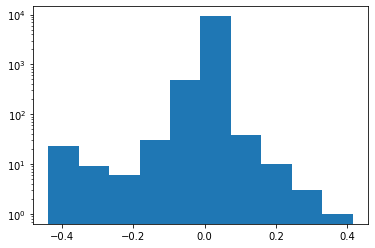

In [30]:
plt.hist((np_pred_means[:, :n_batches, 1:, 0] - np_pred_means[:, :n_batches, 0:1, 0]).reshape(-1), log=True);

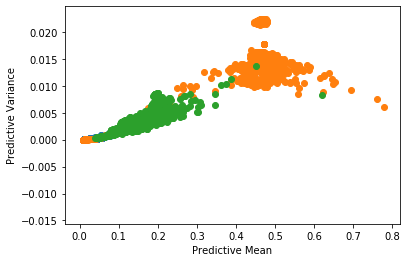

In [31]:
import matplotlib.pyplot as plt

for seq in range(np_pred_means.shape[0]):
    plt.scatter(
        np_pred_means[seq, :, :, :].reshape(-1), 
        np_pred_vars[seq, :, :, :].reshape(-1),
        label=seq)
plt.xlabel("Predictive Mean")
plt.ylabel("Predictive Variance");

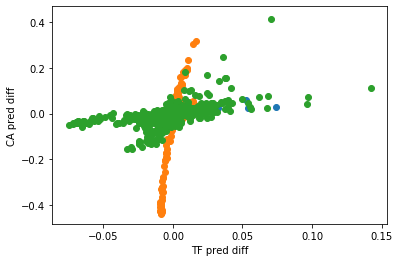

In [32]:
import matplotlib.pyplot as plt


TF_COL = 1
CA_COL = 0

for seq in range(np_pred_means.shape[0]):
    plt.scatter(
        (np_pred_means[seq, :, 1:, TF_COL] - np_pred_means[seq, :, 0:1, TF_COL]).reshape(-1), 
        (np_pred_means[seq, :, 1:, CA_COL] - np_pred_means[seq, :, 0:1, CA_COL]).reshape(-1), 
        label=seq)
plt.xlabel("TF pred diff")
plt.ylabel("CA pred diff");

(6578,)
(3289,)
(6578,)
(3289,)
(6578,)
(3289,)


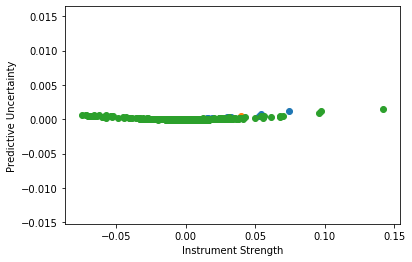

In [40]:
import matplotlib.pyplot as plt

for seq in range(np_pred_means.shape[0]):
    print(np_pred_uncertainties[seq, :, 1:, :].reshape(-1).shape)
    print((np_pred_means[seq, :, 1:, TF_COL] - np_pred_means[seq, :, 0:1, TF_COL]).reshape(-1).shape)
    plt.scatter(
        (np_pred_means[seq, :, 1:, TF_COL] - np_pred_means[seq, :, 0:1, TF_COL]).reshape(-1), 
        np_pred_uncertainties[seq, :, 1:, TF_COL].reshape(-1),
        label=seq)
plt.xlabel("Instrument Strength")
plt.ylabel("Predictive Uncertainty");


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 2 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(0, 299 + 1) instead
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  


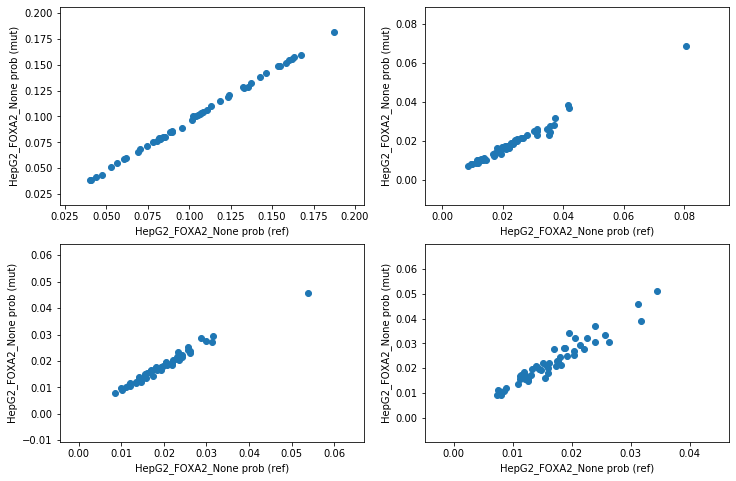

In [41]:
plt.rcParams['figure.figsize'] = [12, 8]
fig, axs = plt.subplots(2, 2)
sample_seqs = np.random.random_integers(0, n_seqs-1, size=4)
sample_batches = np.random.random_integers(0, n_batches-1, size=4)
sample_muts = np.random.random_integers(0, batch_size-1, size=4)
sample_col = np.random.random_integers(0, len(relevant_cols)-1)

for i in range(4):
    np_sample_ref_preds = np_preds[
        :, sample_seqs[i], sample_batches[i], 0, sample_col
    ]
    np_sample_mut_preds = np_preds[
        :, sample_seqs[i], sample_batches[i], sample_muts[i], sample_col
    ]
    axs[i // 2, i % 2].scatter(np_sample_ref_preds, np_sample_mut_preds)
    axs[i // 2, i % 2].set_xlabel(f"{relevant_cols[sample_col][1]} prob (ref)")
    axs[i // 2, i % 2].set_ylabel(f"{relevant_cols[sample_col][1]} prob (mut)")    

In [48]:
import csv


IDX_TO_NT = 'ACGT'

def _convert_to_mutation(pos_nt_pair):
    return "%d%s" % (pos_nt_pair[0], IDX_TO_NT[pos_nt_pair[1]])


TF_COL = 1
CA_COL = 0

def _write_row(writer, seq, batch, i):
    seq_num = seq+1
    mut_num = (batch * (batch_size)) + i
    mut = _convert_to_mutation((mut_num // 3, mut_num % 3))
    x_pred_mean = np_pred_means[seq, batch, i, TF_COL]
    x_pred_uncertainty = np_pred_uncertainties[seq, batch, i, TF_COL]
    y_pred_mean = np_pred_means[seq, batch, i, CA_COL]
    y_pred_uncertainty = np_pred_uncertainties[seq, batch, i, CA_COL]
    writer.writerow(
        {
            "seq_num": seq_num,
            "mut": mut,
            "X_pred_mean": x_pred_mean,
            "X_pred_var": x_pred_uncertainty,
            "Y_pred_mean": y_pred_mean,
            "Y_pred_var": y_pred_uncertainty,
        }
    )
        

with open("../dat/means_and_uncertainties.csv", 'w', newline="") as out_file:
    fieldnames = [
        "seq_num",
        "mut",
        "X_pred_mean",
        "X_pred_var",
        "Y_pred_mean",
        "Y_pred_var",
    ]
    writer = csv.DictWriter(out_file, delimiter=",", fieldnames=fieldnames)
    writer.writeheader()
    
    for seq in range(n_seqs):
        _write_row(writer, seq, batch, i)
        for batch in range(n_batches):
            for i in range(1, batch_size):
                _write_row(writer, seq, batch, i)
 


In [55]:
print(n_seqs * n_batches * (batch_size-1))
print(n_batches)

61200
12


In [ ]:
zeros = np.zeros((2, 3))
def sanitize_scores(scores):
    orig_shape = scores.shape
    sanitized_scores = np.ndarray((*orig_shape, 2, 3), dtype=scores.dtype)
    flattened_scores = scores.reshape(-1)
    
    for i, score in enumerate(flattened_scores):
        idx = np.unravel_index(i, orig_shape)
        if score is None: sanitized_scores[idx] = zeros
        else: sanitized_scores[idx] = np.array(score)
    return sanitized_scores

sanitized_scores = sanitize_scores(np.squeeze(ism_score))
ctcf_original_preds = sanitized_scores[:, :, :, 0, 1]
ctcf_pred_diffs = sanitized_scores[:, :, :, 1, 1]
dnase_original_preds = sanitized_scores[:, :, :, 0, 0]
dnase_pred_diff = sanitized_scores[:, :, :, 1, 0]

In [ ]:
import math
import numpy as np

log_uniform_prop = math.log(.05/(1-.05))
def compute_normalized_prob(prob, train_prob):
    denom = 1+np.exp(-(np.log(prob/(1-prob))+log_uniform_prop-np.log(train_prob/(1-train_prob))))
    return 1 / denom

# Ratios and normalization formula drawn from here: http://deepsea.princeton.edu/media/help/posproportion.txt
tf_compute_normalized_prob = lambda prob: compute_normalized_prob(prob, .020029)
# ENCODE	A549	DNase	None	0.048136
chrom_acc_normalized_prob = lambda prob: compute_normalized_prob(prob, 0.048136)